# Obtaining Jet Mass Shift Resolution Using The Leading W jet of t tbar Events

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import mplhep as hep
import vector

import HH4b.utils as utils
import HH4b.plotting as plotting

In [2]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

## Load Dataset

In [3]:
year = "2022EE"  #
dir_name = "24Apr18_v12_signal"
path_to_dir = f"/eos/uscms/store/user/haoyang/bbbb/ttSkimmer/{dir_name}"

In [4]:
# Load your dataset
samples = {
    "muon": [
        "Muon_Run2022E",
        "Muon_Run2022F",
        "Muon_Run2022G",
    ],
    "tt": ["TTto2L2Nu", "TTto4Q", "TTtoLNu2Q"],
}

dirs = {path_to_dir: samples}

filters = None

# columns to load
# the parquet files are too big so we can only load a few columns at a time without consumming much memory
load_columns = [
    ("weight", 1),
    ("ak8FatJetMsd", 2),
    ("ak8FatJetPNetMass", 2),
    ("ak8FatJetPNetXbb", 2),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")


events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters),
    }

samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(f"Keys in events_dict")
for i in keys_loaded:
    print(i)

Loaded Muon_Run2022E                                     : 20447 entries
Loaded Muon_Run2022F                                     : 65035 entries
Loaded Muon_Run2022G                                     : 10961 entries
Loaded TTto2L2Nu                                         : 618523 entries
Loaded TTto4Q                                            : 12835 entries
Loaded TTtoLNu2Q                                         : 3168087 entries
Keys in events_dict
('ak8FatJetEta', 0)
('ak8FatJetEta', 1)
('ak8FatJetEta', 2)
('ak8FatJetPhi', 0)
('ak8FatJetPhi', 1)
('ak8FatJetPhi', 2)
('ak8FatJetMass', 0)
('ak8FatJetMass', 1)
('ak8FatJetMass', 2)
('ak8FatJetPt', 0)
('ak8FatJetPt', 1)
('ak8FatJetPt', 2)
('ak8FatJetMsd', 0)
('ak8FatJetMsd', 1)
('ak8FatJetMsd', 2)
('ak8FatJetPNetXbb', 0)
('ak8FatJetPNetXbb', 1)
('ak8FatJetPNetXbb', 2)
('ak8FatJetPNetXjj', 0)
('ak8FatJetPNetXjj', 1)
('ak8FatJetPNetXjj', 2)
('ak8FatJetPNetQCD', 0)
('ak8FatJetPNetQCD', 1)
('ak8FatJetPNetQCD', 2)
('ak8FatJetPNetQCD1HF',

## Event cuts

In [5]:
# Higgs candidate selection example
events_raw = pd.concat([events_dict["muon"], events_dict["tt"]], keys=["muon", "tt"])

In [6]:
# AK4OutsideJet pt cut
# jets_outside_raw = make_vector(events_raw, "ak4JetOutside")
# j3_raw = jets_outside_raw[:, 0]
# j4_raw = jets_outside_raw[:, 1]
# j3j4_pt_cut = (j3_raw.pt > 20) & (j4_raw.pt > 20)

In [7]:
# combined_filter = j3j4_pt_cut
# events = events_raw[combined_filter]
events = events_raw

## MC jet

In [8]:
mc = events.loc["tt"]
fatjets_mc = make_vector(mc, "ak8FatJet")
fj_mc_sorted = np.take_along_axis(fatjets_mc, np.argsort(fatjets_mc.pt, axis=1)[:, ::-1], axis=1)
W_jets_mc = fj_mc_sorted[:, 0]

In [9]:
print("mc mean", W_jets_mc.m.mean())
print("mc std", W_jets_mc.m.std())

mc mean 100.40978863919011
mc std 40.76651928050793


## Data jet

In [10]:
data = events.loc["muon"]
fatjets = make_vector(data, "ak8FatJet")
fj_sorted = np.take_along_axis(fatjets, np.argsort(fatjets.pt, axis=1)[:, ::-1], axis=1)
W_jets = fj_sorted[:, 0]

In [11]:
print("data mean", W_jets.m.mean())
print("data std", W_jets.m.std())

data mean 94.2821791687415
data std 39.34382523090672


## Plot Mass

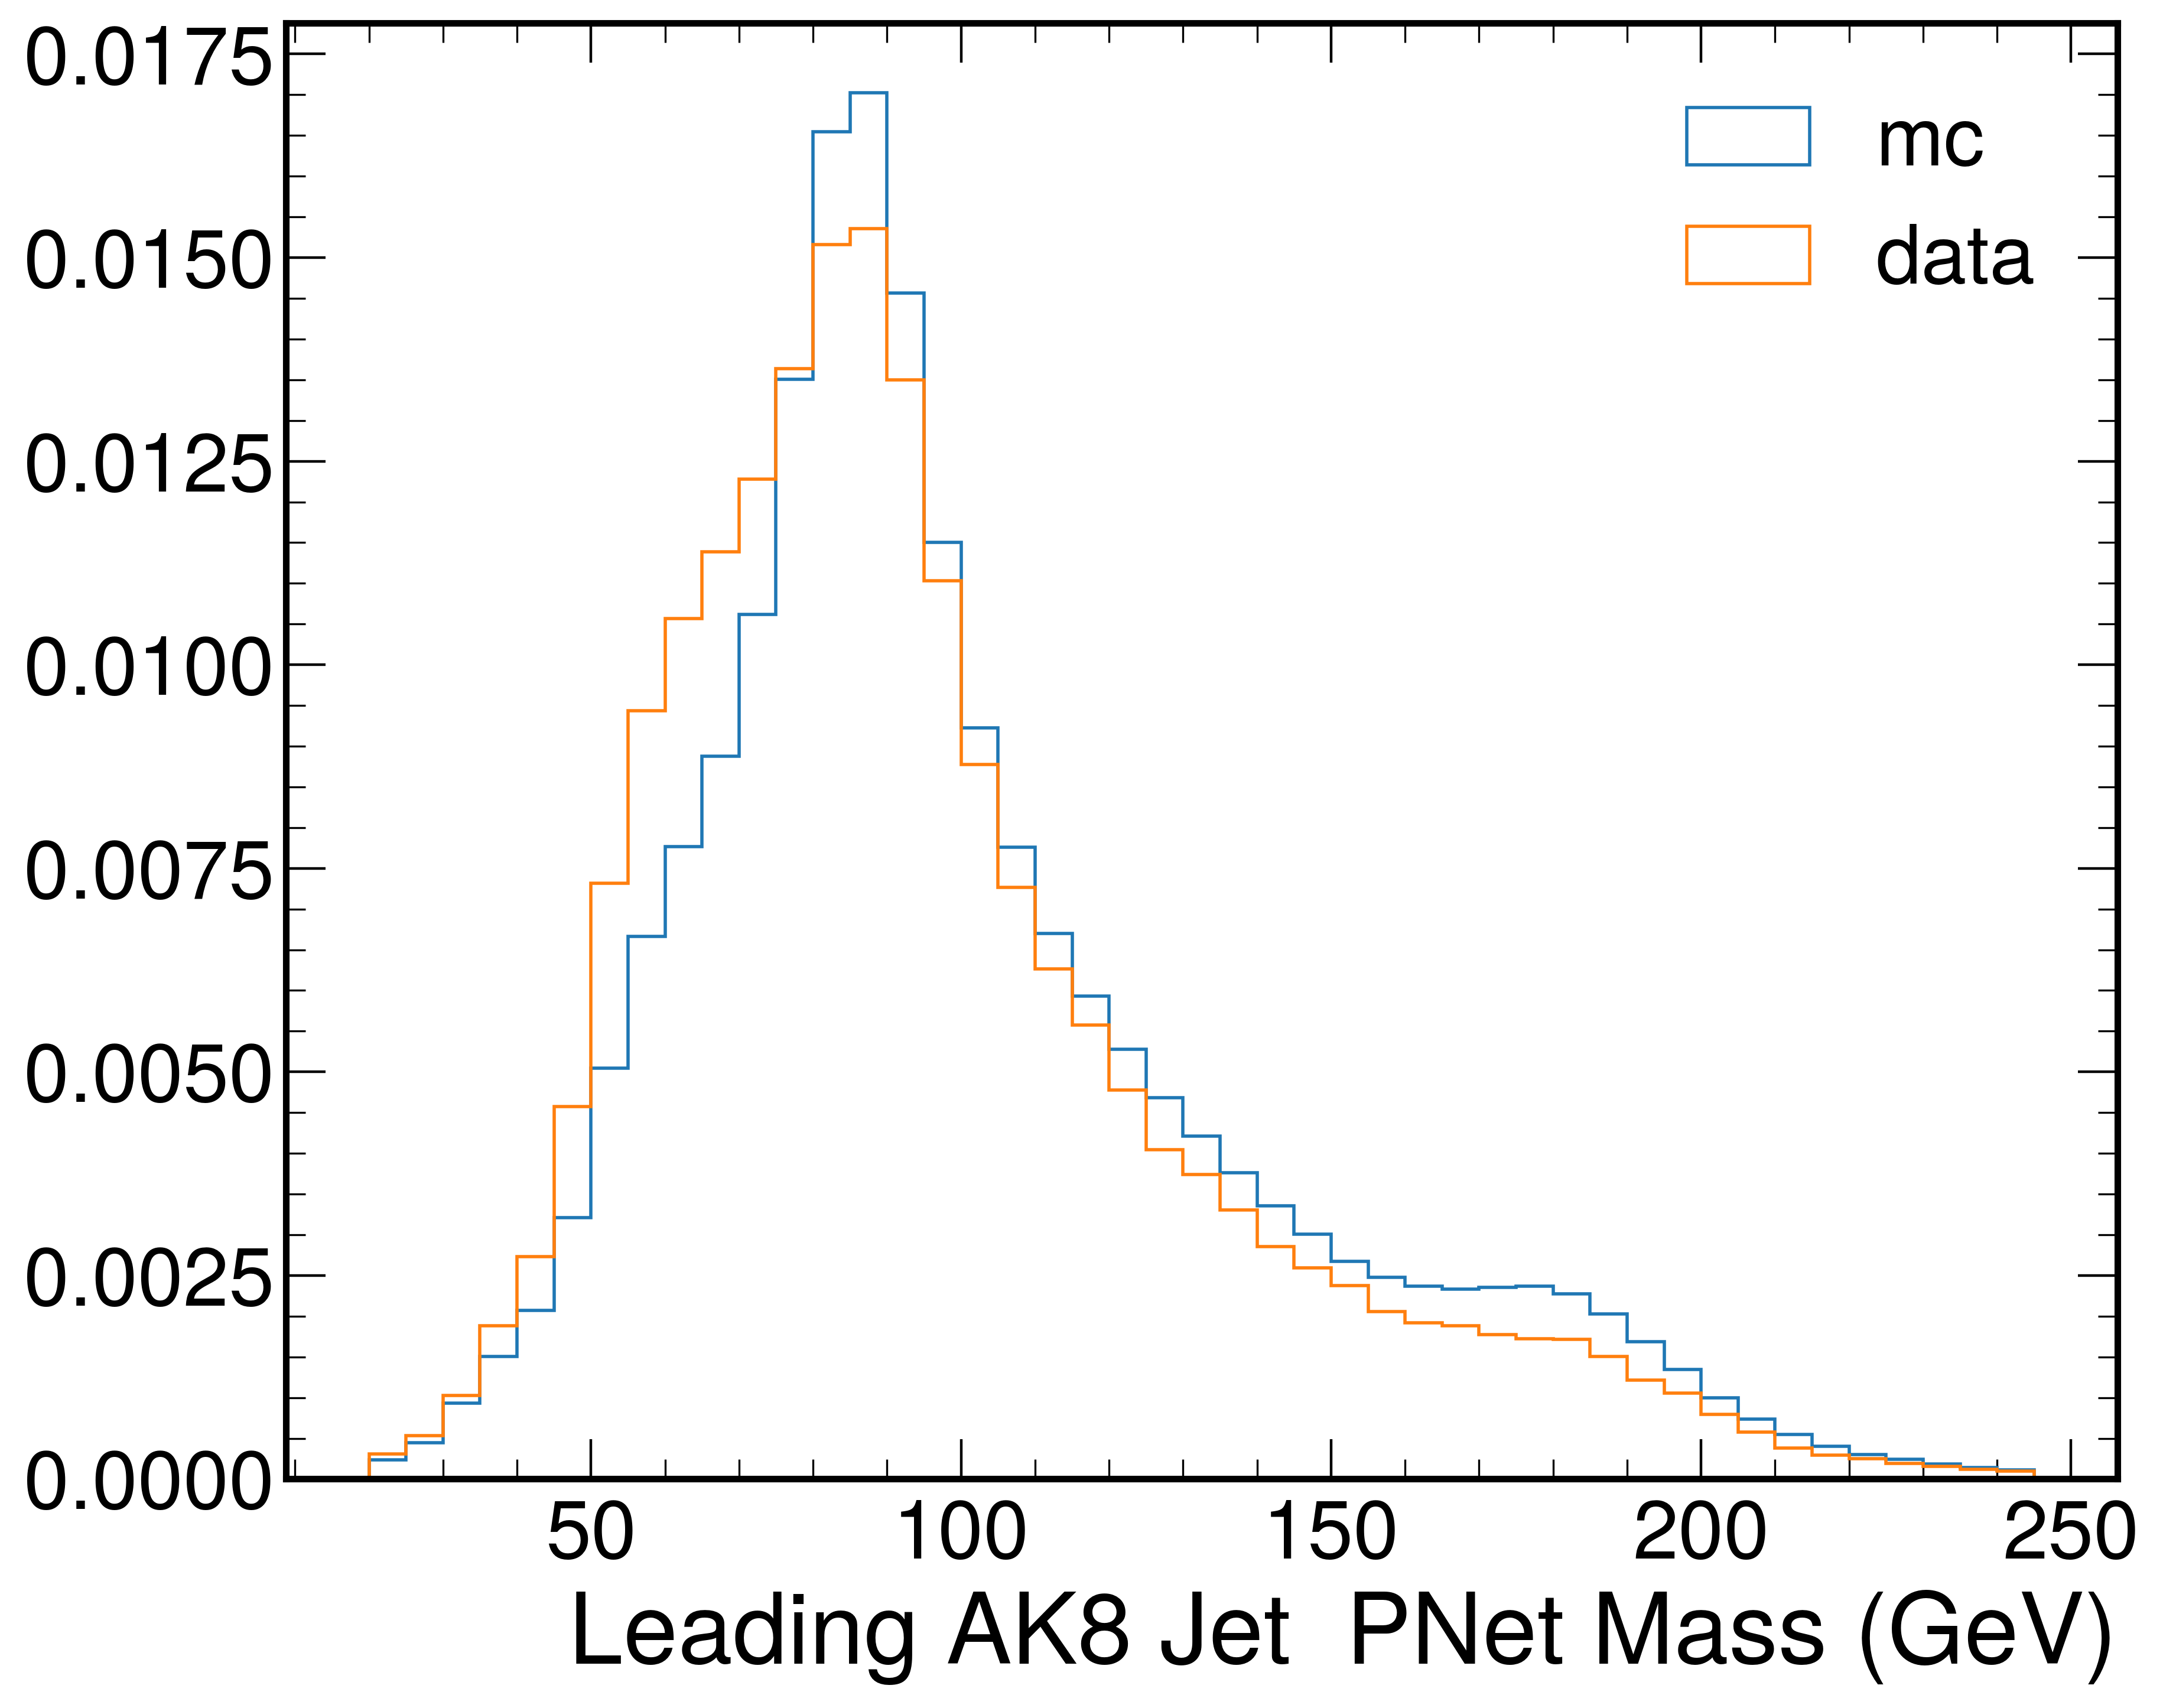

In [12]:
bins = np.arange(20, 250, 5)

plt.figure(figsize=(10, 8))
plt.hist(W_jets_mc.m, bins=bins, label="mc", density=True, histtype="step")
plt.hist(W_jets.m, bins=bins, label="data", density=True, histtype="step")
plt.legend()
plt.xlabel("Leading AK8 Jet  PNet Mass (GeV)")
plt.show()

In [13]:
# Use pandas df as feature container
df = pd.DataFrame()

# H1 features
fatjets = make_vector(events, "ak8FatJet")  # fatjets sorted by xbb
h1 = fatjets[:, 0]
df["logPtH1"] = np.log(h1.pt)  #
df["hb_eta"] = h1.eta  #


# H2 features
jets_outside = make_vector(events, "ak4JetOutside")  # sorted by b-score
j3 = jets_outside[:, 0]
j4 = jets_outside[:, 1]
h2 = j3 + j4
df["hr_pt"] = h2.pt  #
df["hr_eta"] = h2.eta  #
df["hr_mass"] = h2.mass  #

# j3 j4 features
j3_deepJetB = events.ak4JetOutsidebtagDeepFlavB[0]
j4_deepJetB = events.ak4JetOutsidebtagDeepFlavB[1]

pn_b = events.ak4JetOutsidebtagPNetProbb + events.ak4JetOutsidebtagPNetProbbb
pn_c = events.ak4JetOutsidebtagPNetProbc + events.ak4JetOutsidebtagPNetProbcc
pn_uds = events.ak4JetOutsidebtagPNetProbuds
pn_g = events.ak4JetOutsidebtagPNetProbg
ak4JetOutsidePNetFlavB = pn_b / (pn_c + pn_uds + pn_g)
j3_PNetFlavB = ak4JetOutsidePNetFlavB[0]
j4_PNetFlavB = ak4JetOutsidePNetFlavB[1]

j3_btag = j3_PNetFlavB
j4_btag = j4_PNetFlavB

df["logPtJ3"] = np.log(j3.pt)  #
df["logPtJ4"] = np.log(j4.pt)  #
df["j3_btag"] = j3_btag  #
df["j4_btag"] = j4_btag  #

df["dPhiJ3J4"] = j3.deltaphi(j4)
df["dRJ3J4"] = j3.deltaR(j4)  #
df["j3_j4_ratio"] = j3.pt / j4.pt  #

# HH features
hh = h1 + h2
drh1h2 = np.sqrt((h1.eta - h2.eta) ** 2 + (h1.phi - h2.phi) ** 2)

df["logPtHH"] = np.log(hh.pt)  #
df["HHMass"] = hh.M  #
df["HHEta"] = hh.eta  #  #

df["H1Pt_H2Pt"] = h1.pt / h2.pt  #
df["dphi"] = h1.deltaphi(h2)  #
df["deta"] = h1.deltaeta(h2)  #
df["dRH1H2"] = drh1h2  #

# Second fatjet
fj2 = fatjets[:, 1]
df["fj2_pt"] = fj2.pt  #
df["fj2_eta"] = fj2.eta  #
df["fj2_mass"] = fj2.M  #

KeyError: 'ak4JetOutsidePt'

### Collins Sopper Angle

In [ ]:
def calc_abs_cos_theta_star(p1, p2):
    # reference Equ (2)
    # https://terascale.physik.uni-freiburg.de/lehre/ss_14/StudentMaterial/SchleicherProc
    # calculate particles 4 vec in Collins-Soper frame
    rest_frame = -(p1 + p2)
    p1_b = p1.boost_p4(rest_frame)
    p2_b = p2.boost_p4(rest_frame)
    p1p2_b = p1_b + p2_b

    # massless
    factor1_numerator = np.abs(np.sinh(p1_b.deltaeta(p2_b)))
    factor1_denominator = np.sqrt(1 + np.square((p1p2_b.pt) / (p1p2_b.M)))
    factor1 = factor1_numerator / factor1_denominator

    factor2_numerator = 2 * p1_b.pt * p2_b.pt
    factor2_denominator = np.square(p1p2_b.M)
    factor2 = factor2_numerator / factor2_denominator

    return factor1 * factor2

In [ ]:
hh_cos_theta_star = calc_abs_cos_theta_star(h1, h2)
rhbb_cos_theta_star = calc_abs_cos_theta_star(j3, j4)
df["hh_cos_theta_star"] = hh_cos_theta_star
df["rhbb_cos_theta_star"] = rhbb_cos_theta_star

In [ ]:
def calc_abs_cos_theta_star2(p1, p2):
    # reference Equ (2)
    # https://terascale.physik.uni-freiburg.de/lehre/ss_14/StudentMaterial/SchleicherProc
    # calculate particles 4 vec in Collins-Soper frame
    rest_frame = -(p1 + p2)
    p1_b = p1.boost_p4(rest_frame)
    p2_b = p2.boost_p4(rest_frame)

    return np.abs(p1_b.costheta)

In [ ]:
hh_cos_theta_star2 = calc_abs_cos_theta_star2(h1, h2)
rhbb_cos_theta_star2 = calc_abs_cos_theta_star2(j3, j4)
df["hh_cos_theta_star"] = hh_cos_theta_star
df["rhbb_cos_theta_star"] = rhbb_cos_theta_star

In [ ]:
print(hh_cos_theta_star[0:10])
print(hh_cos_theta_star2[0:10])

In [ ]:
# LOAD FEATURES INTO PD DF
features = df.set_index(multiIndex)

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

In [ ]:
# Initialize the BDT model
bdt_model = XGBClassifier(
    n_estimators=196, max_depth=17, learning_rate=0.1, subsample=0.5, random_state=42
)

In [ ]:
# Train the model
bdt_model.fit(X_train, y_train)

In [ ]:
y_scores = bdt_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# histogram for y scores signal & background
# rank by importance

# number of b-jets that can be identified in resolved
# another feather cos(theta_star)

# Plottting
plt.figure()
plt.plot(tpr, fpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.xlabel("Signal (HH)")
plt.ylabel("Background (QCD&ttbar)")
plt.title("ROC")
plt.legend(loc="upper left")
plt.yscale("log")
plt.show()

In [ ]:
print(fpr)
print(tpr)

In [ ]:
# determine importance of the features

importances = bdt_model.feature_importances_

feature_names = df.columns
feature_importance = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

for feature in feature_importance:
    print(f"{feature[0]}: {feature[1]:.3f}")

In [ ]:
hh4b_scores = bdt_model.predict_proba(X_test.loc["hh4b"])[:, 1]
qcd_scores = bdt_model.predict_proba(X_test.loc["qcd"])[:, 1]
ttbar_scores = bdt_model.predict_proba(X_test.loc["ttbar"])[:, 1]

In [ ]:
plt.figure()
plt.hist(hh4b_scores, bins=40, histtype="step", linewidth=1.5, color="darkblue")
plt.hist(qcd_scores, bins=40, histtype="step", linewidth=1.5, color="red")
plt.hist(ttbar_scores, bins=40, histtype="step", linewidth=1.5, color="darkgreen")
plt.legend(["hh4b", "qcd", "ttbar"])
plt.ylabel("Frequency")
plt.xlabel("Prediciton Score")
plt.title("Model Predictions Histogram")
plt.yscale("log")
plt.show()